# Applying XID+CIGALE to Extreme Starbursts
In this notebook, we read in the data files and prepare them for fitting with XID+CIGALE, the SED prior model extension to XID+. Here we focus on the source `HELP_J104631.170+591036.829`. This source is in [Rowan-Robinson et al. 2018](https://arxiv.org/abs/1704.07783) and claimed to have a star formation rate of $> 10^{3}\mathrm{M_{\odot}yr^{-1}}$

Import required modules

In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
priors,_=xidplus.load('XID+CIGALE_ESB32.pkl')

In [3]:
prior_list=Table.read('prior_list.ascii',format='ascii')

(array([ 1.,  2., 12., 35., 50., 38., 25.,  9.,  1.,  1.]),
 array([-5.20775318, -4.79042621, -4.37309923, -3.95577225, -3.53844528,
        -3.1211183 , -2.70379133, -2.28646435, -1.86913738, -1.4518104 ,
        -1.03448343]),
 <a list of 10 Patch objects>)

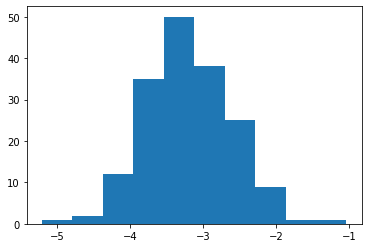

In [4]:
plt.hist(np.log10(prior_list['f_megacam_g']/1000.0))

In [5]:
prior_list['f_irac_i1']

1.31712494543498
1.70243749953889
13.9845644297571
0.718902791346449
7.20627172041193
16.9368640624039
5.25422820780818
--
1.50049386135875
3.22031996449431
6.74205626406394


### Set SED priors
Now lets set the SED priors. Note redshift and temperature need to be transformed into log10. To get the appropriate prior uncertianty, I will use:
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e5a771330b5db50ddce6342c2932604ef0afad23)
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/fc9f7d8cc90a45d4802860f27d2911b09bf4a8a5)

In [6]:
def log10_sig(mu,sig):
    return sig/(mu*np.log(10))

In [7]:
z_mu=np.empty((priors[1].nsrc))
z_sig=np.empty((priors[1].nsrc))
f_irac=np.empty((priors[1].nsrc))
f_irac_sig=np.empty((priors[1].nsrc))
f_opt=np.empty((priors[1].nsrc))
f_opt_sig=np.empty((priors[1].nsrc))
opt=0
for x,i in enumerate(priors[1].ID):
    ind=prior_list['help_id']==i
    z_mu[x]=prior_list['redshift'][ind]
    z_sig[x]=prior_list['redshift_unc'][ind]
    f_irac[x]=prior_list['f_irac_i1'][ind]/1000.0
    f_irac_sig[x]=prior_list['ferr_irac_i1'][ind]/1000.0
    f_opt[x]=prior_list['f_megacam_u'][ind]/1000.0
    f_opt_sig[x]=prior_list['ferr_megacam_u'][ind]/1000.0
    
#transform to log10
#z_sig=log10_sig(z_mu,0.1*z_mu)
#z_sig=log10_sig(z_mu,z_sig)
#z_mu = np.log10(z_mu)
#z_sig[z_sig<0.05]=0.05
sfr_mu=1.5*z_mu+1.0
sfr_sig=np.full(priors[1].nsrc,0.5)

agn_frac_mu=np.full(priors[1].nsrc,-1)
agn_frac_sig=np.full(priors[1].nsrc,1)

(array([2., 2., 0., 2., 2., 0., 0., 0., 1., 1.]),
 array([0.1145 , 0.28562, 0.45674, 0.62786, 0.79898, 0.9701 , 1.14122,
        1.31234, 1.48346, 1.65458, 1.8257 ]),
 <a list of 10 Patch objects>)

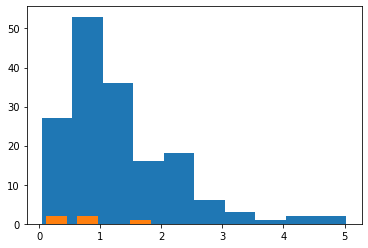

In [8]:
plt.hist(z_mu[np.isfinite(f_irac)])
plt.hist(z_mu[np.isnan(f_irac)])

## Missing IRAC data set to min

In [9]:
f_irac_sig[np.isnan(f_irac)]=np.nanmin(f_irac)
f_irac[np.isnan(f_irac)]=np.nanmin(f_irac)


In [10]:
f_opt_sig[np.isnan(f_opt)]=np.nanmin(f_opt)
f_opt[np.isnan(f_opt)]=np.nanmin(f_opt)

In [11]:

#params_mu=np.vstack((sfr_mu,agn_frac_mu,z_mu)).T
#params_sig=np.vstack((sfr_sig,agn_frac_sig,z_sig)).T
#params_names=['log10sfr','agn_frac','log10z']
#emulator_path='/Users/pdh21/Google_Drive/WORK/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210310_log10sfr_uniformAGN_log10z.pkl'

In [12]:
params_mu=np.vstack((sfr_mu,z_mu)).T
params_sig=np.vstack((sfr_sig,z_sig)).T
params_names=['log10sfr','log10z']
emulator_path='/Users/pdh21/Google_Drive/WORK/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210329_log10sfr_uniformAGN_z_log_irac1_megacam.pkl'

In [13]:
class hier_prior(object):
    def __init__(self,ID,params_mu,params_sig,params_names,emulator_path):
        """Initiate SED prior class
        
        :param params_mu array with mean values of parameters
        :param params_sig array with sigma values of parameters
        :param params_names list of names of params
        :param emulator_path path to saved emulator file"""
        
        from astropy.table import Table, join
        from xidplus.numpyro_fit.misc import load_emulator
        mu_table=Table(params_mu,names=[i+'_mu' for i in params_names])
        sig_table=Table(params_sig,names=[i+'_sig' for i in params_names])
        
        mu_table.add_column(ID, name='ID')
        sig_table.add_column(ID, name='ID')
        import jax.numpy as jnp
        self.prior_table=join(mu_table,sig_table,keys='ID')
        
        self.emulator=load_emulator(emulator_path)
        self.params_mu=jnp.asarray(params_mu)
        self.params_sig=jnp.asarray(params_sig)

In [14]:
phys_prior=hier_prior(priors[1].ID,params_mu,params_sig,params_names,emulator_path)

W0330 09:23:25.902314 4589317568 xla_bridge.py:135] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [24]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam
import jax.numpy as jnp
from jax import random
import numpy as np
import jax
import pickle
import os
from xidplus.numpyro_fit.misc import sp_matmul, load_emulator

numpyro.set_host_device_count(os.cpu_count())

def spire_model_CIGALE(priors,sed_prior):
    pointing_matrices = [([p.amat_row, p.amat_col], p.amat_data) for p in priors]
    bands=[8,9,10]
    bkg_mu= np.asarray([p.bkg[0] for p in priors]).T
    bkg_sig = np.asarray([p.bkg[1] for p in priors]).T
    #lir_mu=numpyro.sample('lir_mu',dist.Normal(10,1))
    #lir_sig=numpyro.sample('lir_sig',dist.HalfCauchy(1,0.5))

    #params_mu=sed_prior.params_mu
    #params_mu[:,0]=lir_mu
    #params_sig=sed_prior.params_sig
    #params_sig[:,0]=lir_sig
    with numpyro.plate('bands', len(priors)):

        #sigma_conf = numpyro.sample('sigma_conf', dist.HalfCauchy(1,0.5))
        bkg = numpyro.sample('bkg', dist.Normal(bkg_mu,bkg_sig))

    m=numpyro.sample('m',dist.Normal(1,0.5))
    c=numpyro.sample('c',dist.Normal(-1,0.5))
  
    sfr_sig=numpyro.sample('sfr_sig',dist.HalfNormal(0.5))

    with numpyro.plate('nsrc', priors[0].nsrc):
        redshift = numpyro.sample('redshift',dist.TruncatedNormal(0.0,sed_prior.params_mu[:,1],sed_prior.params_sig[:,1]))
        agn = numpyro.sample('agn', dist.Beta(1.0,3.0))

        with numpyro.handlers.reparam(config={"params":TransformReparam()}):
                
            sfr = numpyro.sample('sfr', dist.TransformedDistribution(dist.Normal(0.0,1.0),dist.transforms.AffineTransform(redshift*m+c,jnp.full(priors[0].nsrc,sfr_sig))))
        #sfr=numpyro.sample('sfr',dist.Normal(sed_prior.params_mu[:,0],sed_prior.params_sig[:,0]))
        #agn_frac=numpyro.sample('agn_frac',dist.Normal(sed_prior.params_mu[:,1],sed_prior.params_sig[:,1]))
        #redshift=numpyro.sample('redshift',dist.Normal(sed_prior.params_mu[:,2],sed_prior.params_sig[:,2]))

    params = jnp.vstack((sfr[None,:],agn[None,:],redshift[None,:])).T

    src_f=jnp.exp(sed_prior.emulator['net_apply'](sed_prior.emulator['params'],params))[:,bands]

    #src_f = numpyro.sample('src_f', dist.(flux_lower, flux_upper))
    db_hat_psw = sp_matmul(pointing_matrices[0], src_f[:, 1][:, None], priors[0].snpix).reshape(-1) + bkg[0]
    db_hat_pmw = sp_matmul(pointing_matrices[1], src_f[:, 2][:, None], priors[1].snpix).reshape(-1) + bkg[1]
    db_hat_plw = sp_matmul(pointing_matrices[2], src_f[:, 3][:, None], priors[2].snpix).reshape(-1) + bkg[2]

    #sigma_tot_psw = jnp.sqrt(jnp.power(priors[0].snim, 2) + jnp.power(sigma_conf[0], 2))
    #sigma_tot_pmw = jnp.sqrt(jnp.power(priors[1].snim, 2) + jnp.power(sigma_conf[1], 2))
    #sigma_tot_plw = jnp.sqrt(jnp.power(priors[2].snim, 2) + jnp.power(sigma_conf[2], 2))


    with numpyro.plate('psw_pixels', priors[0].snim.size):  # as ind_psw:
        numpyro.sample("obs_psw", dist.Normal(db_hat_psw,priors[0].snim ),
                                 obs=priors[0].sim)
    with numpyro.plate('pmw_pixels', priors[1].snim.size):  # as ind_pmw:
        numpyro.sample("obs_pmw", dist.Normal(db_hat_pmw, priors[1].snim),
                                 obs=priors[1].sim)
    with numpyro.plate('plw_pixels', priors[2].snim.size):  # as ind_plw:
        numpyro.sample("obs_plw", dist.Normal(db_hat_plw, priors[2].snim),
                                 obs=priors[2].sim)
        
def spire_model_trunc_irac(priors,sed_prior,irac,irac_error):
    pointing_matrices = [([p.amat_row, p.amat_col], p.amat_data) for p in priors]
    bands=[8,9,10,6]
    bkg_mu= np.asarray([p.bkg[0] for p in priors]).T
    bkg_sig = np.asarray([p.bkg[1] for p in priors]).T
    #lir_mu=numpyro.sample('lir_mu',dist.Normal(10,1))
    #lir_sig=numpyro.sample('lir_sig',dist.HalfCauchy(1,0.5))

    #params_mu=sed_prior.params_mu
    #params_mu[:,0]=lir_mu
    #params_sig=sed_prior.params_sig
    #params_sig[:,0]=lir_sig
    with numpyro.plate('bands', len(priors)):

        #sigma_conf = numpyro.sample('sigma_conf', dist.HalfCauchy(1,0.5))
        bkg = numpyro.sample('bkg', dist.Normal(bkg_mu,bkg_sig))

    m=numpyro.sample('m',dist.Normal(1,0.5))
    c=numpyro.sample('c',dist.Normal(-1,0.5))
  
    sfr_sig=numpyro.sample('sfr_sig',dist.HalfNormal(0.5))

    with numpyro.plate('nsrc', priors[0].nsrc):
        redshift = numpyro.sample('redshift',dist.TruncatedNormal(0.0,sed_prior.params_mu[:,1],sed_prior.params_sig[:,1]))
        agn = numpyro.sample('agn', dist.Beta(1.0,3.0))

        with numpyro.handlers.reparam(config={"params":TransformReparam()}):
                
            sfr = numpyro.sample('sfr', dist.TransformedDistribution(dist.Normal(0.0,1.0),dist.transforms.AffineTransform(redshift*m+c,jnp.full(priors[0].nsrc,sfr_sig))))
        #sfr=numpyro.sample('sfr',dist.Normal(sed_prior.params_mu[:,0],sed_prior.params_sig[:,0]))
        #agn_frac=numpyro.sample('agn_frac',dist.Normal(sed_prior.params_mu[:,1],sed_prior.params_sig[:,1]))
        #redshift=numpyro.sample('redshift',dist.Normal(sed_prior.params_mu[:,2],sed_prior.params_sig[:,2]))

    params = jnp.vstack((sfr[None,:],agn[None,:],redshift[None,:])).T

    src_f=jnp.exp(sed_prior.emulator['net_apply'](sed_prior.emulator['params'],params))[:,bands]

    #src_f = numpyro.sample('src_f', dist.(flux_lower, flux_upper))
    db_hat_psw = sp_matmul(pointing_matrices[0], src_f[:, 0][:, None], priors[0].snpix).reshape(-1) + bkg[0]
    db_hat_pmw = sp_matmul(pointing_matrices[1], src_f[:, 1][:, None], priors[1].snpix).reshape(-1) + bkg[1]
    db_hat_plw = sp_matmul(pointing_matrices[2], src_f[:, 2][:, None], priors[2].snpix).reshape(-1) + bkg[2]

    
    #sigma_tot_psw = jnp.sqrt(jnp.power(priors[0].snim, 2) + jnp.power(sigma_conf[0], 2))
    #sigma_tot_pmw = jnp.sqrt(jnp.power(priors[1].snim, 2) + jnp.power(sigma_conf[1], 2))
    #sigma_tot_plw = jnp.sqrt(jnp.power(priors[2].snim, 2) + jnp.power(sigma_conf[2], 2))
    with numpyro.plate('irac_cat',irac_error.size):
        numpyro.sample('obs_irac',dist.Normal(src_f[:,3],irac_error),obs=irac)

    with numpyro.plate('psw_pixels', priors[0].snim.size):  # as ind_psw:
        numpyro.sample("obs_psw", dist.Normal(db_hat_psw,priors[0].snim ),
                                 obs=priors[0].sim)
    with numpyro.plate('pmw_pixels', priors[1].snim.size):  # as ind_pmw:
        numpyro.sample("obs_pmw", dist.Normal(db_hat_pmw, priors[1].snim),
                                 obs=priors[1].sim)
    with numpyro.plate('plw_pixels', priors[2].snim.size):  # as ind_plw:
        numpyro.sample("obs_plw", dist.Normal(db_hat_plw, priors[2].snim),
                                 obs=priors[2].sim)

## Generate Prior Predictive Distribtion

In [25]:
from numpyro.infer import Predictive
from jax import random, vmap
from xidplus.numpyro_fit import SED_prior

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [26]:

## FOr numpyro to sample from the prior, the data needs to be set to None
import copy
#make a deepcopy of the priors
priors_prior_pred=copy.deepcopy(priors)
#set data to None
for i in range(0,len(priors)):
    priors_prior_pred[i].sim=None

In [27]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive=Predictive(spire_model_trunc,posterior_samples = {}, num_samples = 50,)
prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred[1:],phys_prior)

CPU times: user 9.53 s, sys: 186 ms, total: 9.71 s
Wall time: 10 s


In [28]:
#Create a list of the model map arrays
mod_map_array=[prior_pred['obs_psw'].T,prior_pred['obs_pmw'].T,prior_pred['obs_plw'].T]

In [29]:
import jax.numpy as jnp


params = jnp.stack((prior_pred['sfr'].T,prior_pred['agn'].T,prior_pred['redshift'].T)).T
src_f_2=np.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'],params))

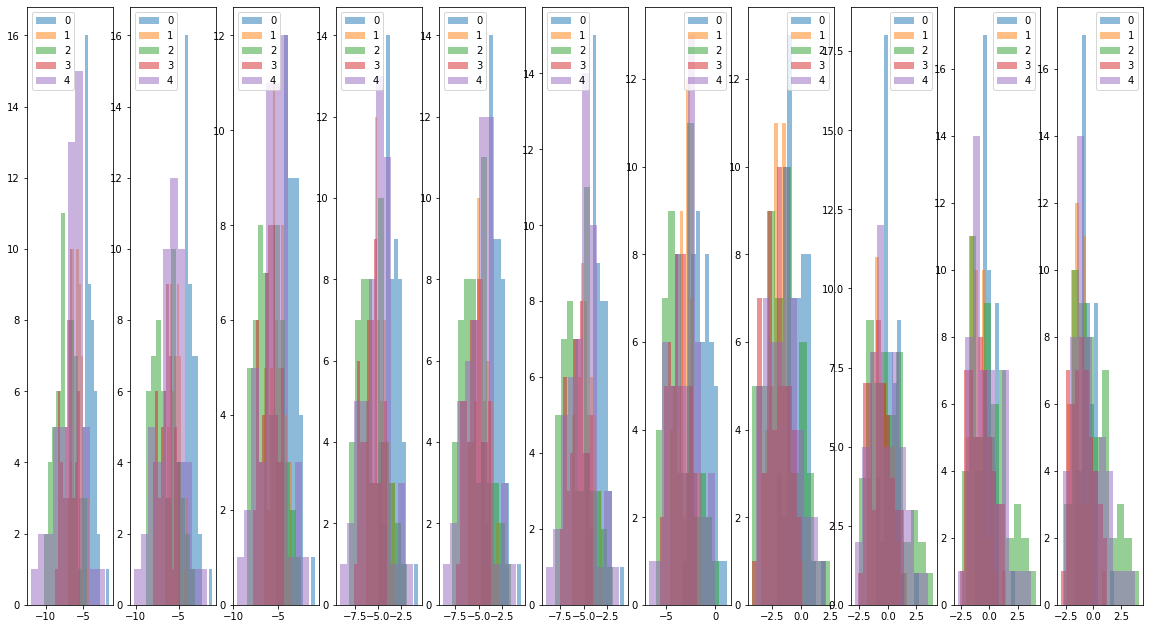

In [30]:
fig,axes=plt.subplots(1,src_f_2.shape[-1],figsize=(20,src_f_2.shape[-1]))
for j in range(0,src_f_2.shape[-1]):
    for i in range(0,5):
        axes[j].hist(np.log10(src_f_2[:,i,j]),label=str(i),alpha=0.5)
    axes[j].legend()

In [ ]:
from numpyro.diagnostics import summary
import jax.numpy as jnp
import os
numpyro.set_host_device_count(os.cpu_count())
from operator import attrgetter
num_samp=1
all_samples=[]
all_stats=[]
all_divergences=[]
for s in [2]:
    #make a deepcopy of the priors
    priors_prior_pred_samp=copy.deepcopy(priors)[1:]
    #set data to sample data
    for i in range(0,3):
        priors_prior_pred_samp[i].sim=mod_map_array[i][:,s]
    nuts_kernel = NUTS(spire_model_trunc_irac,init_strategy=numpyro.infer.init_to_median(),max_tree_depth=20)
    mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=500,num_chains=1)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key,priors_prior_pred_samp,phys_prior,src_f_2[s,:,6],f_irac_sig)
    all_samples.append(mcmc.get_samples())
    all_divergences.append(mcmc.get_extra_fields()['diverging'])
    prob = 0.9
    exclude_deterministic = True
    sites = mcmc._states[mcmc._sample_field]
    if isinstance(sites, dict) and exclude_deterministic:
        state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
        # XXX: there might be the case that state.z is not a dictionary but
        # its postprocessed value `sites` is a dictionary.
        # TODO: in general, when both `sites` and `state.z` are dictionaries,
        # they can have different key names, not necessary due to deterministic
        # behavior. We might revise this logic if needed in the future.
        if isinstance(state_sample_field, dict):
            sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                     if k in state_sample_field}

    stats_summary = summary(sites, prob=prob)
    all_stats.append(stats_summary)

warmup:   1%|          | 12/1000 [09:34<44:53:46, 163.59s/it, 621117 steps of size 5.62e-12. acc. prob=0.05]

In [119]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive_fit=Predictive(spire_model_trunc,posterior_samples = all_samples[0], num_samples = 50,)
prior_pred_fit=prior_predictive_fit(random.PRNGKey(0),priors_prior_pred,phys_prior)
mod_map_array_fit=[prior_pred_fit['obs_psw'].T,prior_pred_fit['obs_pmw'].T,prior_pred_fit['obs_plw'].T]

CPU times: user 2.4 s, sys: 46.5 ms, total: 2.45 s
Wall time: 3.09 s


In [120]:
xidplus.plots.make_map_animation(priors_prior_pred_samp,mod_map_array_fit,50)

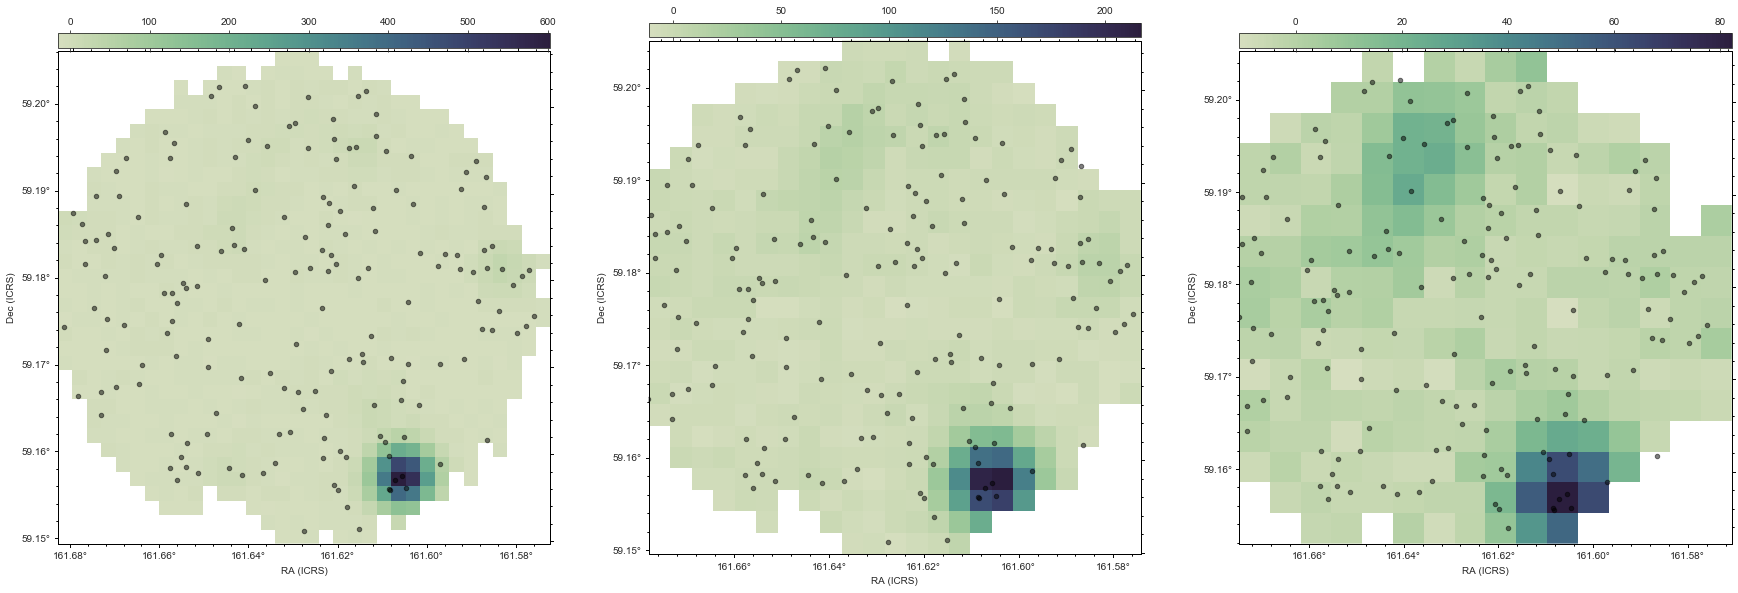

In [121]:
figures,fig=xidplus.plot_map(priors_prior_pred_samp)

## Fit Real data

In [33]:
nuts_kernel = NUTS(spire_model_trunc,init_strategy=numpyro.infer.init_to_median())
mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=500,num_chains=2)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,priors[1:],phys_prior)

sample: 100%|██████████| 1000/1000 [07:27<00:00,  2.23it/s, 511 steps of size 9.72e-03. acc. prob=0.93] 


In [75]:
(7.0*1.0/priors[0].moc.area_sq_deg)/60.0/100.0

0.488465560828814

In [36]:
from operator import attrgetter
from numpyro.diagnostics import summary
import jax.numpy as jnp
import os
samples=mcmc.get_samples()
divergences=mcmc.get_extra_fields()['diverging']
prob = 0.9
exclude_deterministic = True
sites = mcmc._states[mcmc._sample_field]
if isinstance(sites, dict) and exclude_deterministic:
    state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
    # XXX: there might be the case that state.z is not a dictionary but
    # its postprocessed value `sites` is a dictionary.
    # TODO: in general, when both `sites` and `state.z` are dictionaries,
    # they can have different key names, not necessary due to deterministic
    # behavior. We might revise this logic if needed in the future.
    if isinstance(state_sample_field, dict):
        sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                 if k in state_sample_field}

stats_summary = summary(sites, prob=prob)

(array([83., 35., 26., 11.,  7.,  2.,  4.,  2.,  3.,  1.]),
 array([0.99802756, 0.9987082 , 0.99938875, 1.0000694 , 1.00075   ,
        1.0014305 , 1.0021112 , 1.0027918 , 1.0034723 , 1.004153  ,
        1.0048336 ], dtype=float32),
 <a list of 10 Patch objects>)

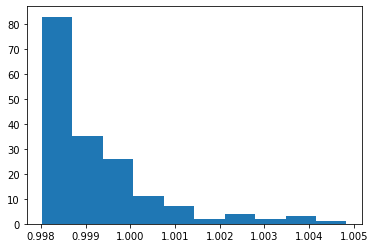

In [44]:
plt.hist(stats_summary['agn']['r_hat'])

(array([0.09599806, 0.09599817, 0.28799418, 0.19199623, 0.76798491,
        1.15197737, 0.6719868 , 0.28799426, 0.86398303, 0.3839924 ]),
 array([-2.26837   , -2.0600324 , -1.8516951 , -1.6433575 , -1.4350201 ,
        -1.2266827 , -1.0183452 , -0.8100078 , -0.6016703 , -0.3933329 ,
        -0.18499544], dtype=float32),
 <a list of 10 Patch objects>)

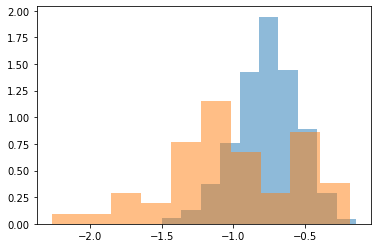

In [42]:
plt.hist(samples['c'][:],alpha=0.5,normed=True)
plt.hist(prior_pred['c'],alpha=0.5,normed=True)

In [49]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive_samp=Predictive(spire_model_trunc,posterior_samples = samples, num_samples = 50)
prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred[1:],phys_prior)
mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]

CPU times: user 2.31 s, sys: 71.2 ms, total: 2.38 s
Wall time: 2.54 s


In [50]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors[1:],mod_map_array_samp,50)

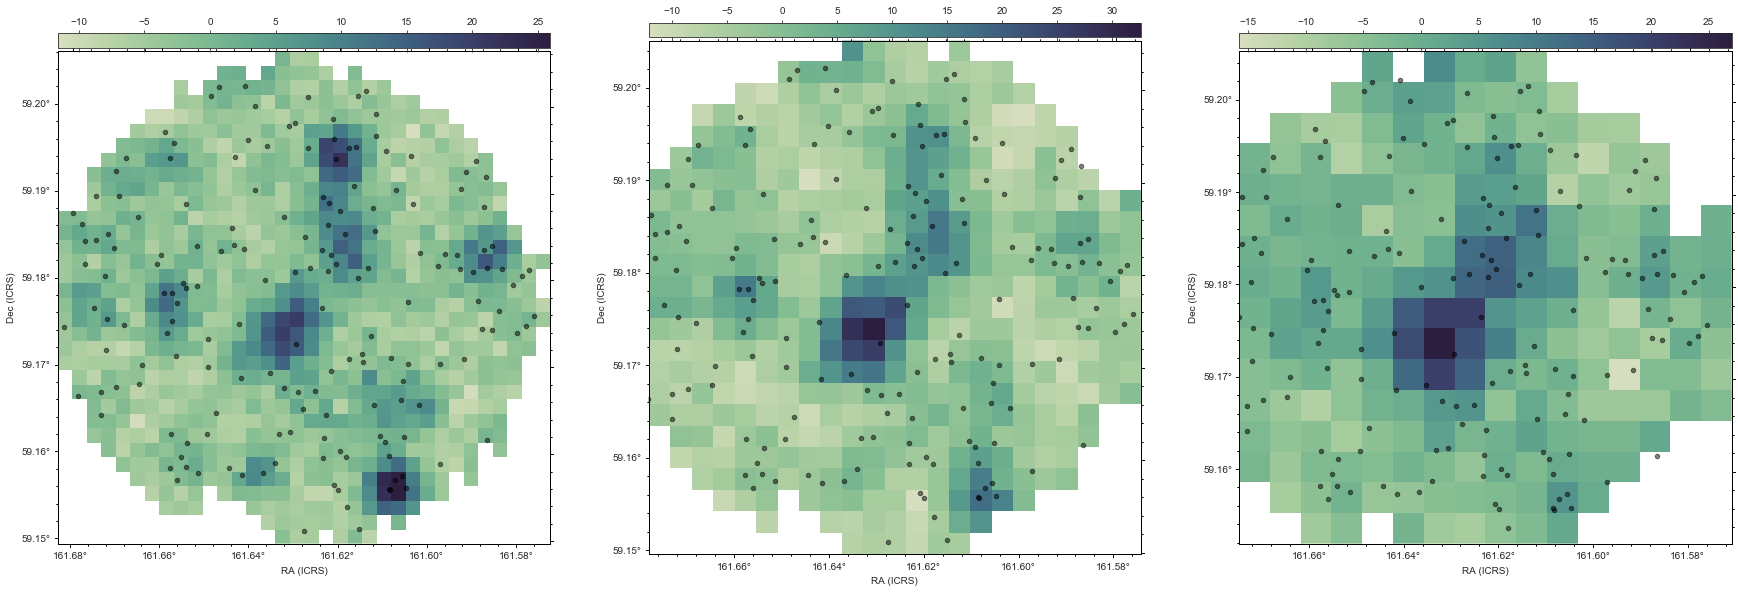

In [51]:
figures,fig=xidplus.plot_map(priors[1:])

Text(0, 0.5, 'Redshift')

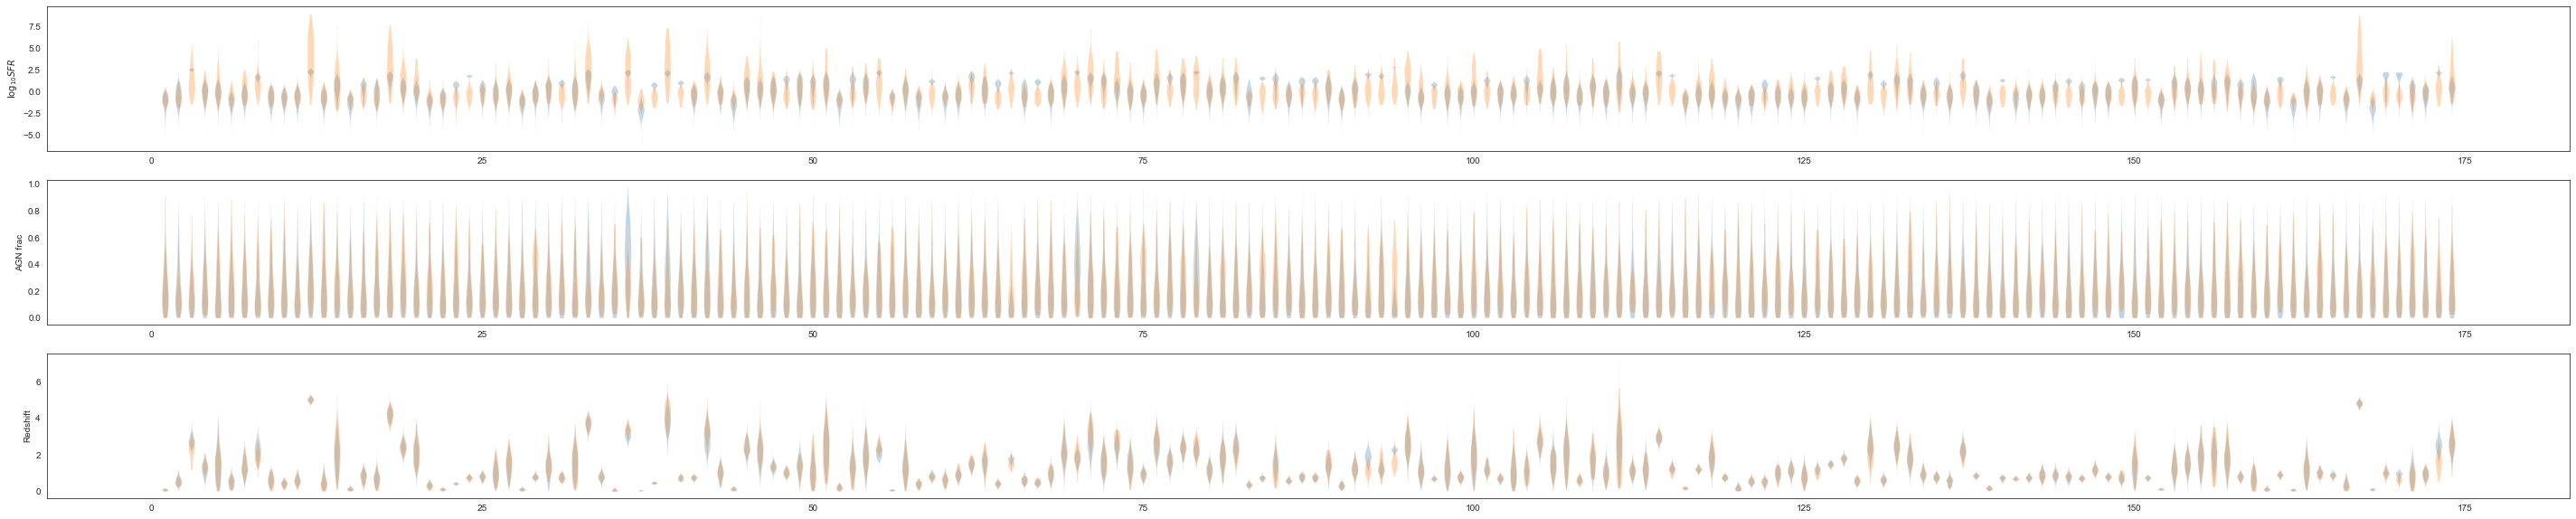

In [64]:
fig,axes=plt.subplots(3,1,figsize=(50,10))
axes[0].violinplot(samples['sfr'].T,showextrema=False);
axes[0].violinplot(prior_pred['sfr'].T,showextrema=False);
axes[0].set_ylabel('$\log_{10} SFR$')
axes[1].violinplot(samples['agn'].T,showextrema=False);
axes[1].violinplot(prior_pred['agn'].T,showextrema=False);
axes[1].set_ylabel('AGN frac')
axes[2].violinplot(samples['redshift'].T,showextrema=False);
axes[2].violinplot(prior_pred['redshift'].T,showextrema=False);
axes[2].set_ylabel('Redshift')